## CITE-Seq analysis
(adapted from [Processing and integrating 5k PBMCs CITE-seq data by Danila Bredikhin](https://muon-tutorials.readthedocs.io/en/latest/cite-seq/1-CITE-seq-PBMC-5k.html))

- Data availability: [Atlas of Human Breast Cancers](https://singlecell.broadinstitute.org/single_cell/study/SCP1039/a-single-cell-and-spatially-resolved-atlas-of-human-breast-cancers#/)

In [62]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pegasus as pg
import anndata
import warnings

from scanpy.experimental.pp import highly_variable_genes

sc.settings.verbosity = 0
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=anndata.ImplicitModificationWarning)

In [6]:
msi_output = pd.read_csv("msisensor_pipeline/msisensor_output.csv")
msi_output.set_index('sample_id', inplace = True)

In [7]:
# Data loading
rna_data_path = "data/SCP1039/expression"
rna = sc.read_10x_mtx(rna_data_path)

The following code block merely does some data wrangling to parse out our patient of interest from the massive 100K dataset
We make a mask of the original dataframe for downstream analysis.

In [133]:
rna_adata = rna.copy()

# patient barcodes are in obs_names followed by cell barcode
rna_adata.obs['patient'] = rna_adata.obs_names.str.split('_').str[0]
rna_adata.obs['cell_bc'] = rna_adata.obs_names
print("Unique patients:", rna_adata.obs['patient'].unique())

# patients of interest
patient = ["CID3586", "CID3838", "CDI3921", "CID3941", "CID3946", "CID3948", "CID3963"]
patient_mask = rna_adata.obs['patient'].isin(patient)
assert msi_output.index.isin(rna_adata.obs_names).all(), "ID Mismatch!"

masked = rna_adata[patient_mask]
merged_obs = masked.obs.merge(
        msi_output,
        left_on = 'cell_bc',
        right_index = True,
        how = 'left'
)

# Patient Colors
masked.obs['patient'] = masked.obs['patient'].astype('category')
p_categories = masked.obs['patient'].cat.categories
c = sns.color_palette("mako", n_colors = len(p_categories))
patient_colors = dict(zip(p_categories, c))
masked.uns['patient_colors'] = list(patient_colors.values())

masked.obs = merged_obs

Unique patients: ['CID3586' 'CID3921' 'CID45171' 'CID3838' 'CID4066' 'CID44041' 'CID4465'
 'CID4495' 'CID44971' 'CID44991' 'CID4513' 'CID4515' 'CID4523' 'CID3946'
 'CID3963' 'CID4461' 'CID4463' 'CID4471' 'CID4530N' 'CID4535' 'CID4040'
 'CID3941' 'CID3948' 'CID4067' 'CID4290A' 'CID4398']


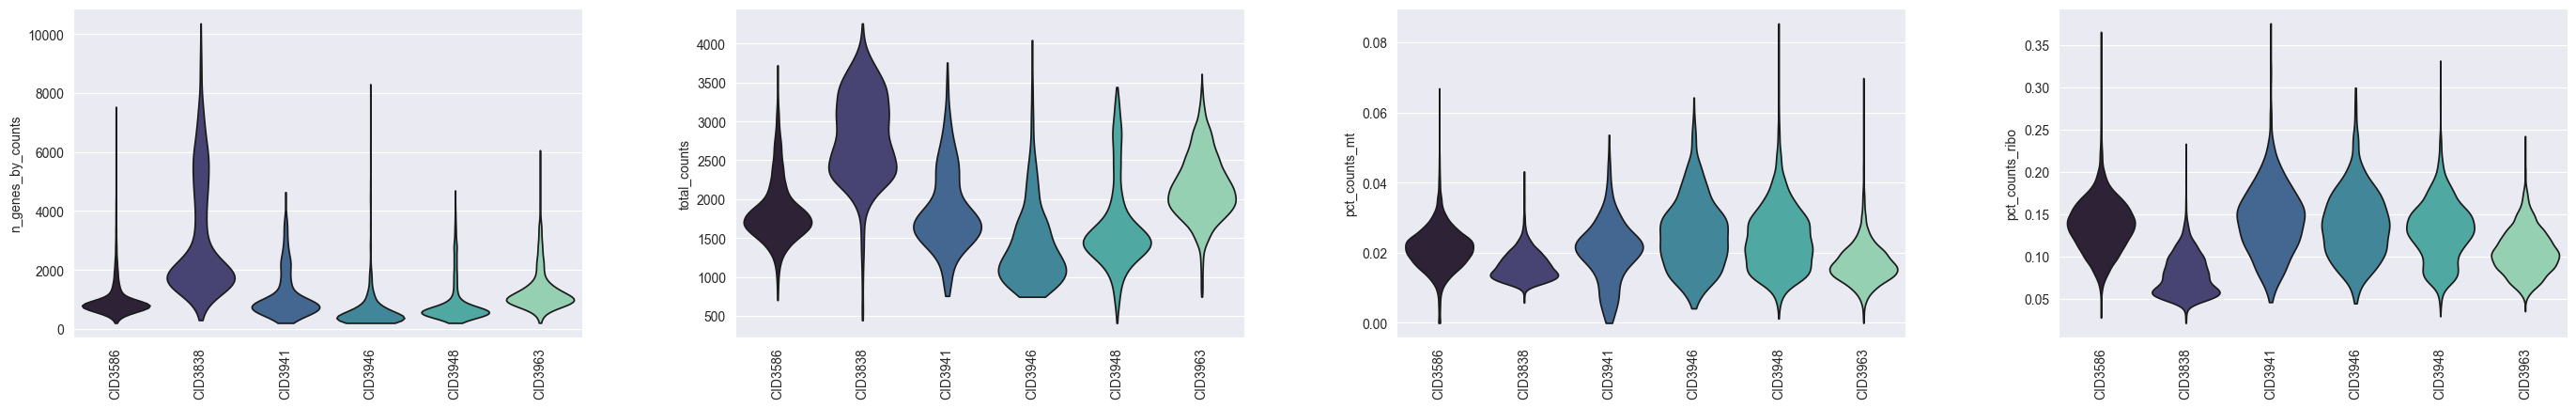

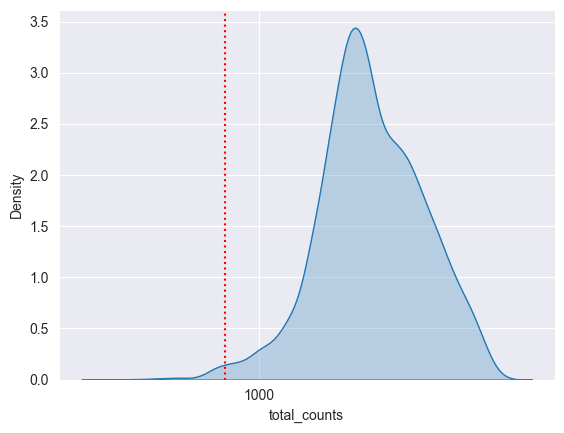

In [134]:
masked_qc = masked.copy()
masked_qc.var['mt'] = masked_qc.var_names.str.startswith('MT-')
masked_qc.var['ribo'] = masked_qc.var_names.str.startswith(('RPS', 'RPL'))

sc.pp.calculate_qc_metrics(
    masked_qc, 
    qc_vars=['mt','ribo'],
    percent_top=None,
    log1p=False,
    inplace=True,
)

masked_qc.obs.pct_counts_mt = masked_qc.obs.pct_counts_mt/100
masked_qc.obs.pct_counts_ribo = masked_qc.obs.pct_counts_ribo/100

sc.pl.violin(masked_qc,
             ['n_genes_by_counts',
              'total_counts',
              'pct_counts_mt',
              'pct_counts_ribo'],
             color = patient_colors,
             groupby = 'patient',
             rotation=90, stripplot=False,
             save = 'cell_type.png')

density = sns.kdeplot(masked_qc.obs['total_counts'], shade=True, log_scale=True)
density.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.axvline(825, color='red', linestyle=':')
plt.savefig("figures/total_counts.kdeplot.raw.png")
plt.show()

The following code performs QC and clustering on the masked dataset
1. first we filter genes that do not contain at least 10 cells
2. Then we normalize the total genes and perform log1p scaling
3. Then we filter the genes that are highly variable in the subset
4. This subset of data is used to perform dimensionality reduction and leiden clustering

Total number of cells: 15790
Number of cells after MT filter: 15777
Number of cells after Ribo filter: 12358
Number of cells after Count filter: 10703
Number of cells after Count filter: 10703


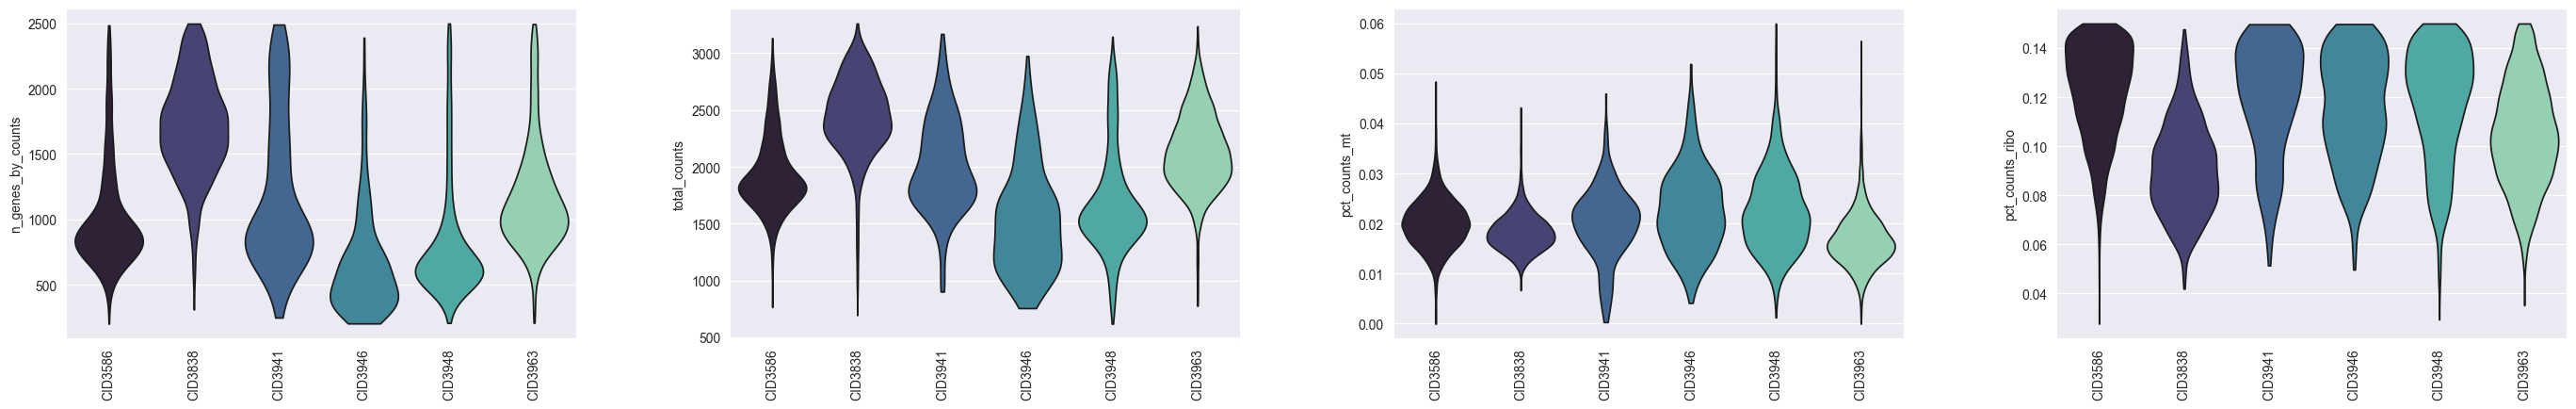

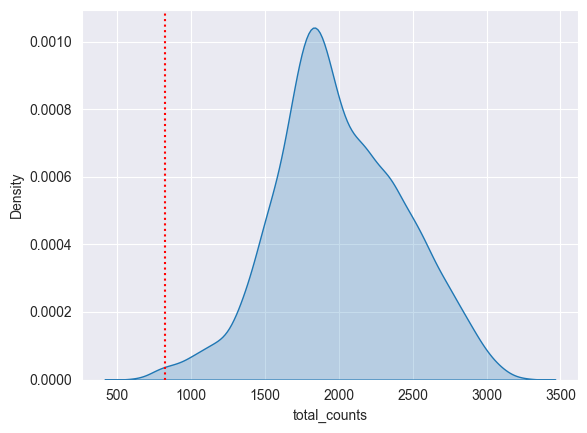

In [135]:
patient_filtered = masked_qc.copy()

max_mt_ratio = 0.06
max_ribo_ratio = 0.15
max_counts = 2500
min_counts = 200
min_cells = 10
min_genes = 200

sc.pp.calculate_qc_metrics(patient_filtered, inplace=True)
print(f'Total number of cells: {patient_filtered.n_obs:d}')

patient_filtered = patient_filtered[patient_filtered.obs.pct_counts_mt < max_mt_ratio]
print(f'Number of cells after MT filter: {patient_filtered.n_obs:d}')

patient_filtered = patient_filtered[patient_filtered.obs.pct_counts_ribo < max_ribo_ratio]
print(f'Number of cells after Ribo filter: {patient_filtered.n_obs:d}')

patient_filtered = patient_filtered[patient_filtered.obs.n_genes_by_counts < max_counts]
print(f'Number of cells after Count filter: {patient_filtered.n_obs:d}')

patient_filtered = patient_filtered[patient_filtered.obs.n_genes_by_counts > min_counts]
print(f'Number of cells after Count filter: {patient_filtered.n_obs:d}')

# filter and normalize
sc.pp.highly_variable_genes(patient_filtered, n_top_genes=2000)
sc.pp.filter_genes(patient_filtered, min_cells = 10)
sc.pp.normalize_total(patient_filtered, target_sum = 1e4)
sc.pp.log1p(patient_filtered)

# highest genes
rna_hvg = patient_filtered[:, patient_filtered.var.highly_variable]
sc.pp.scale(rna_hvg, max_value = 10)

# dimensionality reduction
sc.pp.pca(rna_hvg, n_comps = 50)
sc.pp.neighbors(rna_hvg, n_neighbors = 16, n_pcs = 30)

# clustering
sc.tl.leiden(rna_hvg, resolution = 0.5, flavor = "igraph", n_iterations = 2)
sc.tl.umap(rna_hvg)

# copy back to dataset
patient_filtered.obs['leiden'] = rna_hvg.obs['leiden']

sc.pl.violin(patient_filtered,
             ['n_genes_by_counts',
              'total_counts',
              'pct_counts_mt',
              'pct_counts_ribo'],
             color = patient_colors,
             groupby = 'patient',
             rotation=90, stripplot=False,
             save = 'cell_type.png')

density = sns.kdeplot(patient_filtered.obs['total_counts'], shade=True, log_scale=False)
density.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.axvline(825, color='red', linestyle=':')
plt.savefig("figures/total_counts.kdeplot.filtered.png")

The following code ranks the gene groups and generates a heatmap based on the cluster grouping and differential expression.
Key points:
- We use the `pts=True` function in the `rank_gene_groups` to calculate percentage of cells expressing the genes.
- We use the `tie_correct=True` function to gain more accurate p-values for expression enrichment.

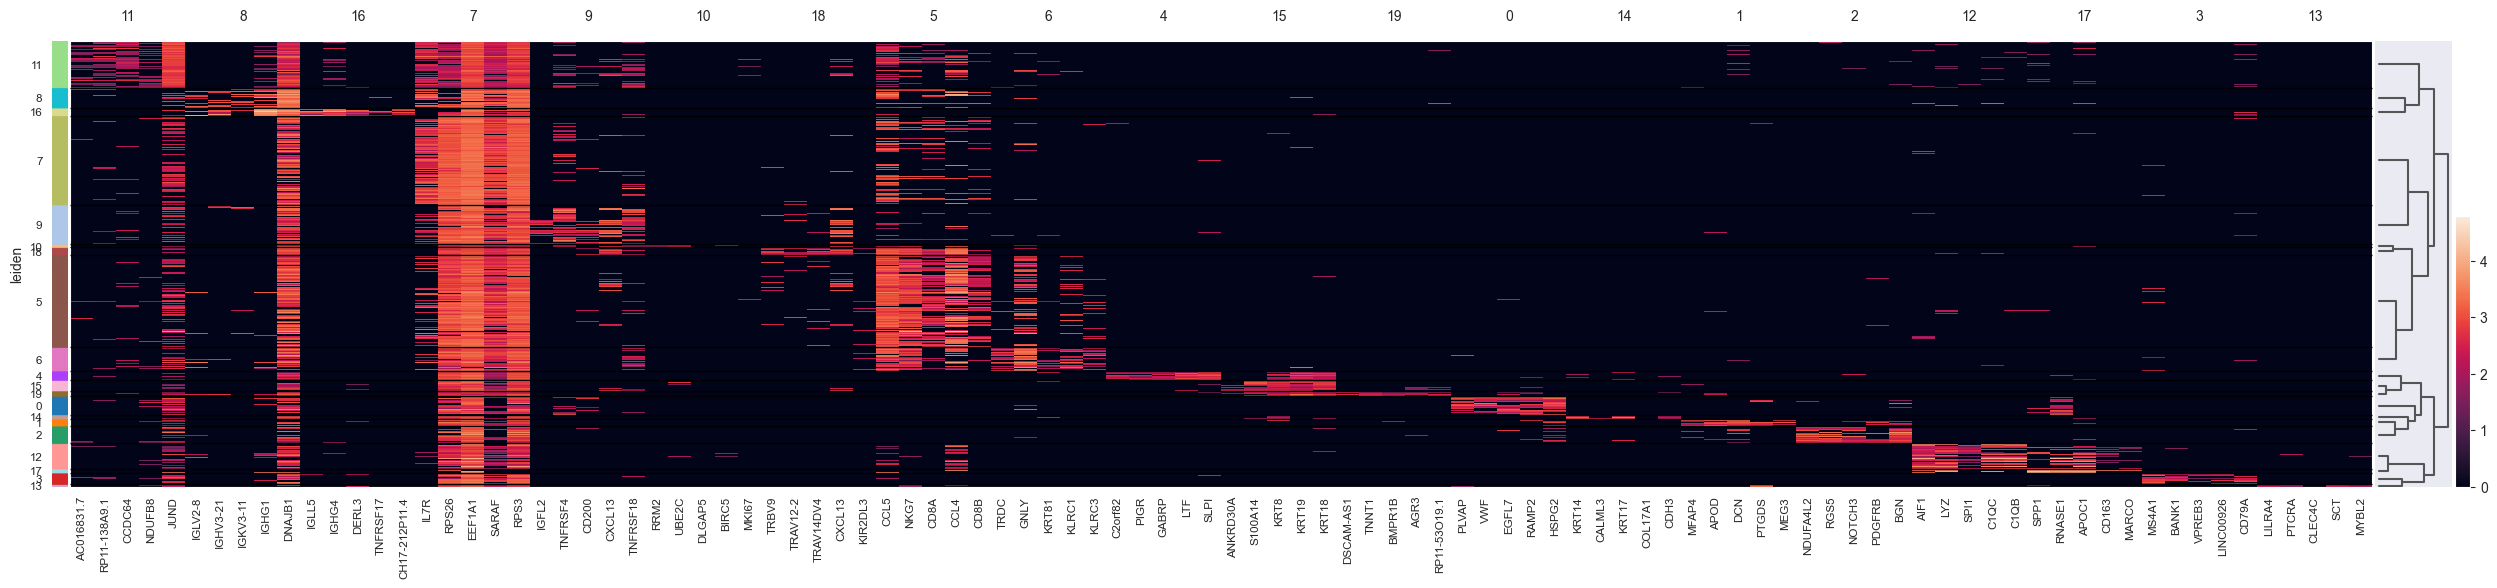

In [136]:
rna_filtered = patient_filtered.copy()

# explicitly use raw or log-normal data. helps with the scaling
if 'raw' in rna_filtered.__dict__ and rna_filtered.raw is not None:
    rna_for_de = rna_filtered
    use_raw = True
else:
    rna_for_de = rna_filtered
    use_raw = False

# rank gene groups.
sc.tl.rank_genes_groups(rna_for_de, 'leiden',
                        method = 'wilcoxon',
                        use_raw = use_raw,
                        pts = True,
                        tie_correct = True)

sc.pl.rank_genes_groups_heatmap(rna_for_de, n_genes = 5,
                                groupby = 'leiden',
                                show_gene_labels = True,
                                dendrogram = True)

<Figure size 1200x1000 with 0 Axes>

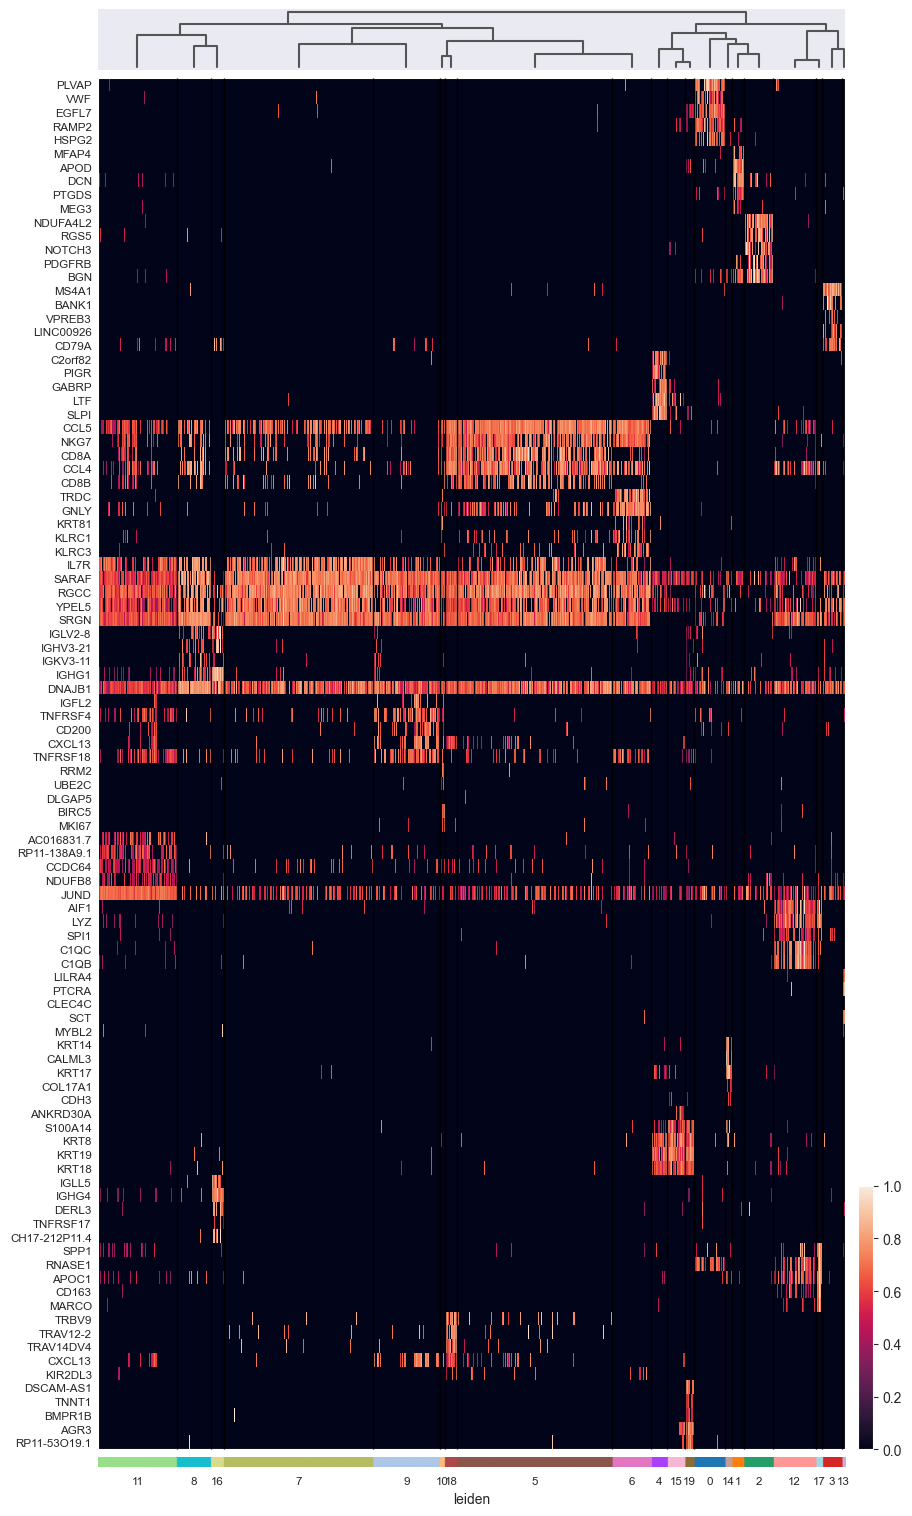

In [137]:
marker_genes = []
for i in range(len(rna_filtered.obs['leiden'].cat.categories)):
    markers_df = sc.get.rank_genes_groups_df(rna_for_de, group = str(i))
    filtered_markers = markers_df[(markers_df['pvals_adj'] < 0.05) &
                                  (markers_df['logfoldchanges'].abs() > 1)]
    if not filtered_markers.empty:
        marker_genes.extend(filtered_markers['names'][:5].tolist())  # Top 5 genes per cluster

# marker gene heatmap
if marker_genes:
    plt.figure(figsize = (12, 10))
    sc.pl.heatmap(rna_filtered, marker_genes, groupby = 'leiden',
                  dendrogram = True, standard_scale = 'var',
                  swap_axes = True, show_gene_labels = True)


In [138]:
# alternate ranking of genes
sc.tl.rank_genes_groups(rna_for_de, 'leiden',
                        method = 'wilcoxon',
                        use_raw = use_raw,
                        key_added = 'wilcoxon_fixed',
                        pts = True,
                        min_in_group_fraction = 0.1,
                        min_fold_change = 1.5)


The final part of the expression analysis is performing the neighbors clustering on the highly differentiated genes. What is nice about this is we get better subcluster resolution than against the whole data
Ultimately this is most useful for identifying any subclusters that have differentially expressed CDs that can be used for our MSI model prediction.

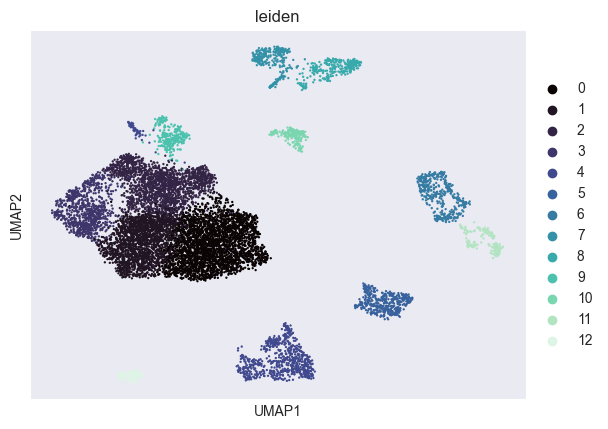

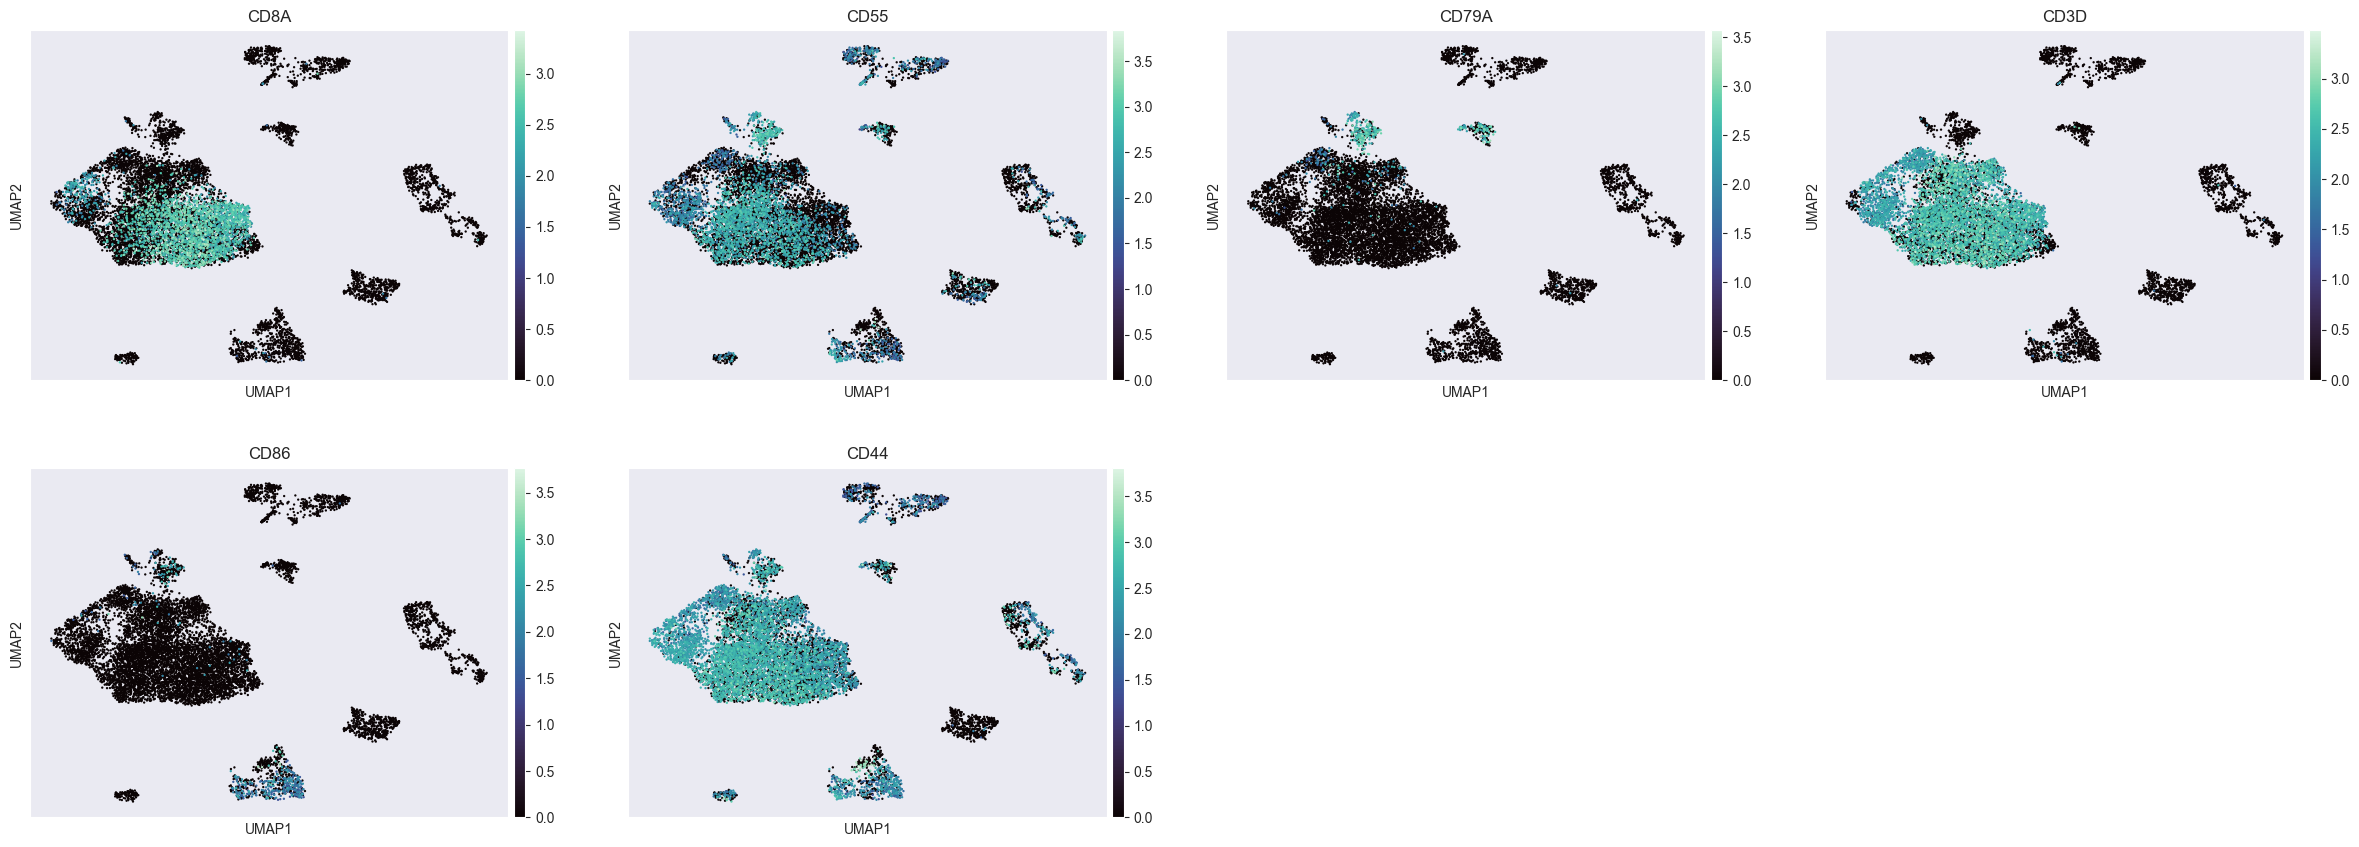

In [139]:
# Re-run analysis on this subset
sc.pp.neighbors(rna_filtered, n_neighbors = 15, n_pcs = 30)
sc.tl.leiden(rna_filtered, resolution = 0.4)  # Lower resolution for finer subclustering

sc.tl.umap(rna_filtered)
sc.pl.umap(rna_filtered, color = 'leiden', palette = 'mako')

# fill in more markers here
rna_markers = ['CD8A', 'CD55', 'CD79A', 'CD3D', 'CD86', 'CD44']
markers_in_data = [m for m in rna_markers if m in rna_filtered.var_names]
sc.pl.umap(rna_filtered, color = markers_in_data, cmap = 'mako')

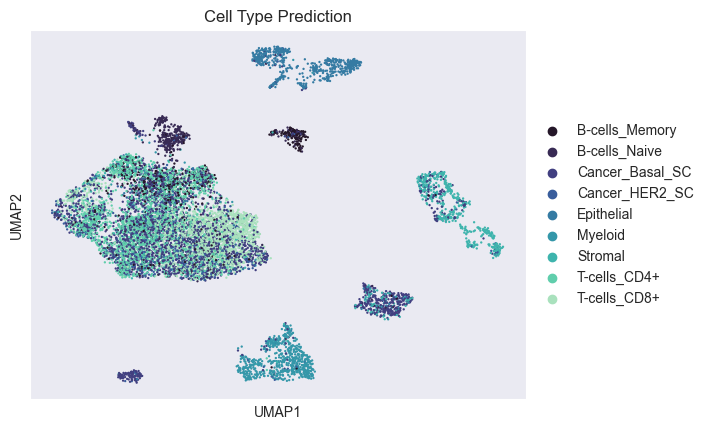

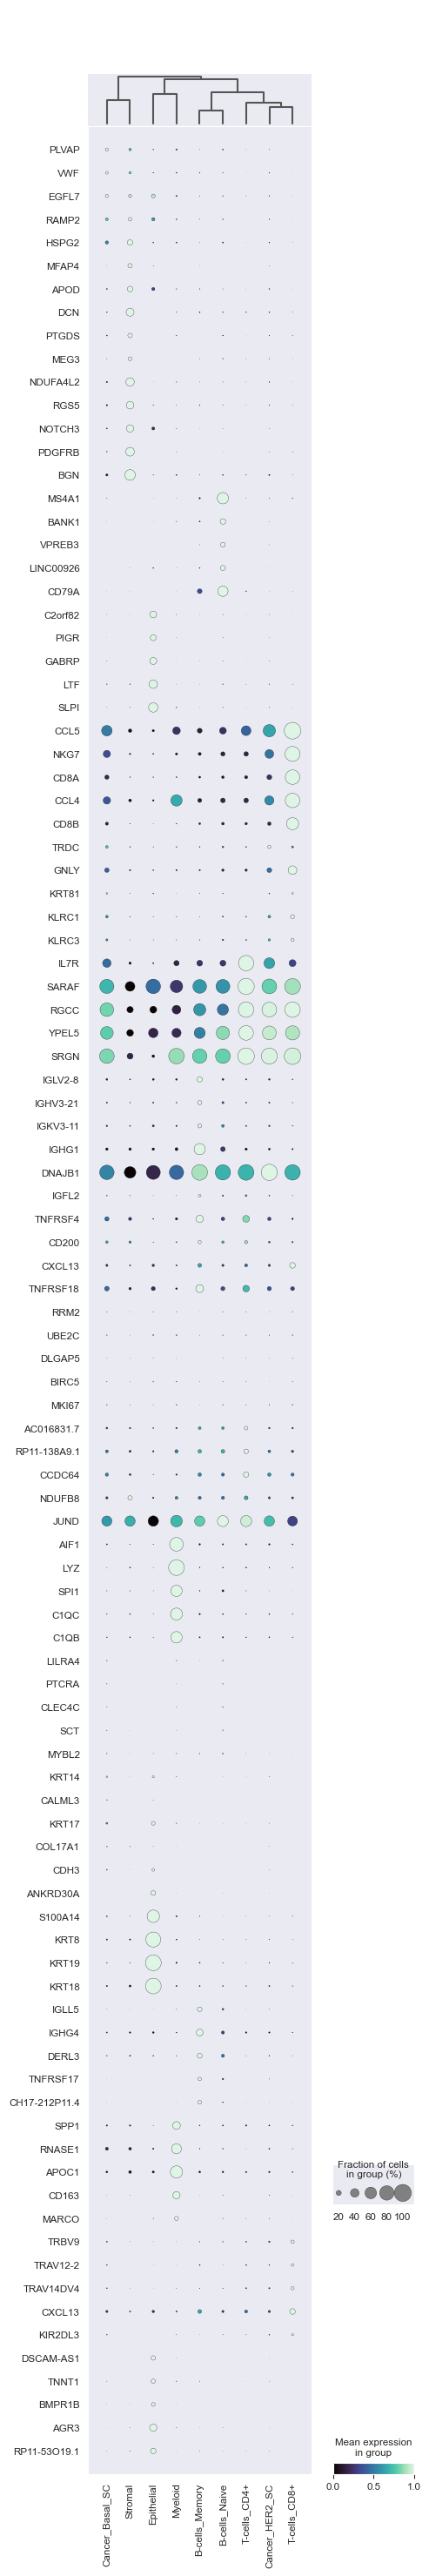

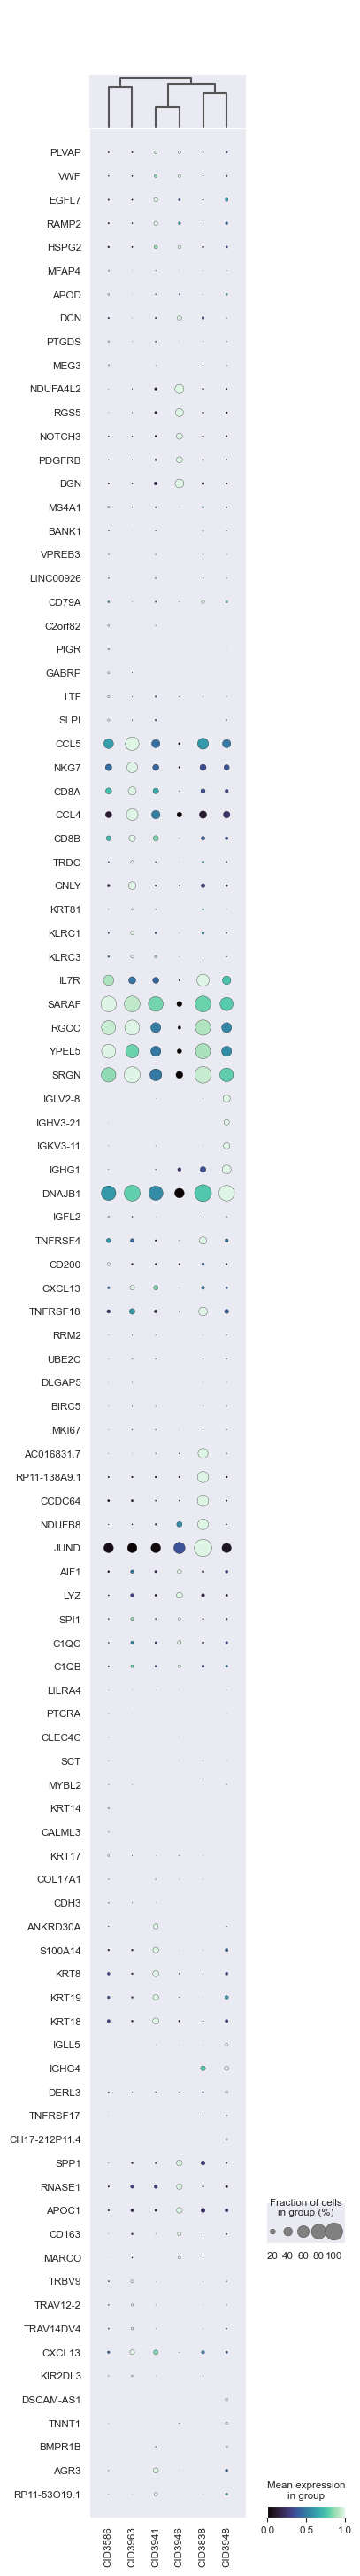

TypeError: Can't implicitly convert non-string objects to strings

In [160]:
cell_markers = {
    'B-cells_Memory' : ['CD79A', 'MS4A1', 'CD27', 'CD80', 'CD86', 'IGHG1'],
    'B-cells_Naive'  : ['CD79A', 'MS4A1', 'IgD', 'CD38lo', 'CD27-', 'IGHM'],
    'Cancer_Basal_SC': ['CD271', 'p63', 'KRT5', 'KRT17', 'VIM', 'ITGA1'],
    'Cancer_HER2_SC' : ['CD44', 'CD24-', 'ALDH1', 'ERBB2', 'EGR1', 'MUC1'],
    'Epithelial'     : ['KRT18', 'KRT19', 'EPCAM', 'KRT8', 'CDH1', 'MUC1'],
    'Myeloid'        : ['CD14', 'LYZ', 'CSF1R', 'CD11b', 'CD11c', 'CD16', 'HLA-DR'],
    'Stromal'        : ['COL1A1', 'FAP', 'ACTA2', 'PDGFRA', 'PDGFRB', 'VIM', 'CXCL12'],
    'T-cells_CD4+'   : ['CD3D', 'CD4', 'IL7R', 'CXCR3', 'CCR4', 'CCR6'],
    'T-cells_CD8+'   : ['CD3D', 'CD8A', 'CD8B', 'GZMA', 'PRF1', 'GZMB', 'TBX21'],
}

# cell type scores
for cell_type, markers in cell_markers.items():
    markers_in_data = [m for m in markers if m in rna_filtered.var_names]
    if markers_in_data:
        sc.tl.score_genes(rna_filtered, markers_in_data, score_name = f'{cell_type}_score')

# predicted cell type
cell_type_columns = [f'{ct}_score' for ct in cell_markers.keys() if f'{ct}_score' in rna_filtered.obs.columns]
rna_filtered.obs['predicted_celltype'] = rna_filtered.obs[cell_type_columns].idxmax(axis = 1)
rna_filtered.obs['predicted_celltype'] = rna_filtered.obs['predicted_celltype'].str.replace('_score', '')

# Create a custom color palette for cell types
c = sns.color_palette("mako", n_colors = len(cell_markers.keys()), desat = 1)
celltype_colors = dict(zip(cell_markers.keys(), c))

# Plot a single UMAP with cell types as colors
sc.pl.umap(rna_filtered,
           color = 'predicted_celltype',
           palette = celltype_colors,
           title = 'Cell Type Prediction')

sc.pl.dotplot(rna_for_de, marker_genes, cmap = 'mako',
              groupby = 'predicted_celltype',
              dendrogram = True,
              standard_scale = 'var',
              swap_axes = True)

sc.pl.dotplot(rna_for_de, marker_genes, cmap = 'mako',
              groupby = 'patient',
              dendrogram = True,
              standard_scale = 'var',
              swap_axes = True)



Predicting MSI is the main feature of this code. We can subset the rna_filtered adata frame to more specifically score the individual cells based on their expression of a few marker genes.


['DUSP4', 'GZMB', 'GNLY', 'GZMH', 'TNFSF9']


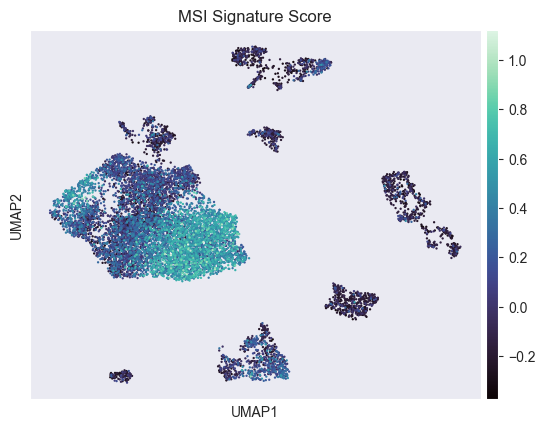

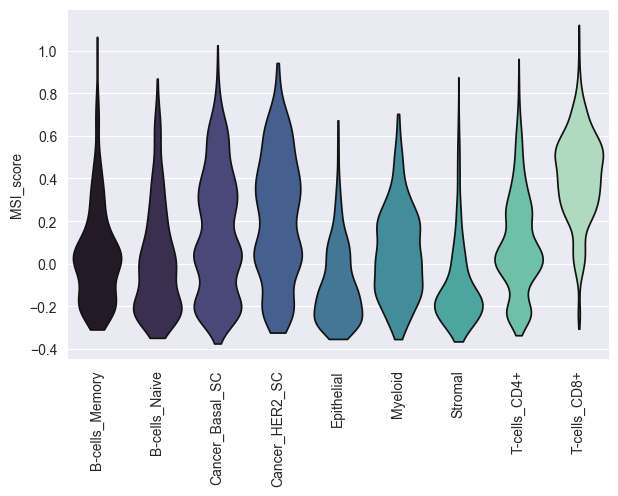

In [141]:
rna_for_de = rna_filtered

sc.tl.rank_genes_groups(
        rna_for_de,
        groupby = 'msi_status',
        method = 'wilcoxon',
        reference = 'MSS'
)
# 
# # Filter for genes with |log2FC| > 1 and adjusted p < 0.05
sc.tl.filter_rank_genes_groups(
        rna_for_de,
        min_fold_change = 2,  # Equivalent to log2FC=1
        min_in_group_fraction = 0.1,
        max_out_group_fraction = 0.75,
        compare_abs = True
)

de_df = sc.get.rank_genes_groups_df(
        rna_for_de,
        group = 'MSI-H',
        key = 'rank_genes_groups_filtered'
).dropna(subset = ['names'])

# sc.pl.rank_genes_groups_dotplot(
#     rna_for_de,
#     n_genes=10,
#     key='rank_genes_groups_filtered',
#     values_to_plot='logfoldchanges',
#     cmap='bwr',
#     swap_axes=True
# )

top_genes = de_df.head(10)['names'].tolist()

print(top_genes) 

msi_genes = ['WRN', 'MLH1', 'MSH2', 'MSH3', 'MSH6', # well-characterized msi-genes
             'UCEC', 'COAD', 'STAD', 'READ', 'DUSP4', 'CCL5', 'CCL4', # generated from differential expression
             # 'CD8A', 'PMS2', 'BAX', 'TGFBR2', 'ACVR2A', 'SEC31A',
             # 'NDUFC2', 'KIAA2018', 'SLC22A9', 'ASTE1', 'LTN1', 'PRDM2',
             # 'JAK1', 'TFAM', 'SMC6', 'CCDC168', 'SPINK5', 'LINE1'
             'TP53', 'PIK3CA', 'ESR1', 'ASM'] # cancer activation pathways

sc.tl.score_genes(rna_filtered, msi_genes, score_name = 'MSI_score')

sc.pl.umap(rna_filtered,
           color = 'MSI_score',
           color_map = 'mako',
           title = 'MSI Signature Score')
sc.pl.violin(rna_filtered, 'MSI_score', groupby = 'predicted_celltype', rotation = 90, palette = celltype_colors,
             hue = 'predicted_celltype', stripplot = False)

# Generate plot


2025-03-31 15:37:01,723 - pegasus.tools.diff_expr - INFO - CSR matrix is converted to CSC matrix. Time spent = 0.0610s.
2025-03-31 15:37:07,492 - pegasus.tools.diff_expr - INFO - MWU test and AUROC calculation are finished. Time spent = 5.7689s.
2025-03-31 15:37:07,521 - pegasus.tools.diff_expr - INFO - Sufficient statistics are collected. Time spent = 0.0298s.
2025-03-31 15:37:07,531 - pegasus.tools.diff_expr - INFO - Differential expression analysis is finished.
2025-03-31 15:37:07,534 - pegasus.tools.diff_expr - INFO - Function 'de_analysis' finished in 5.92s.


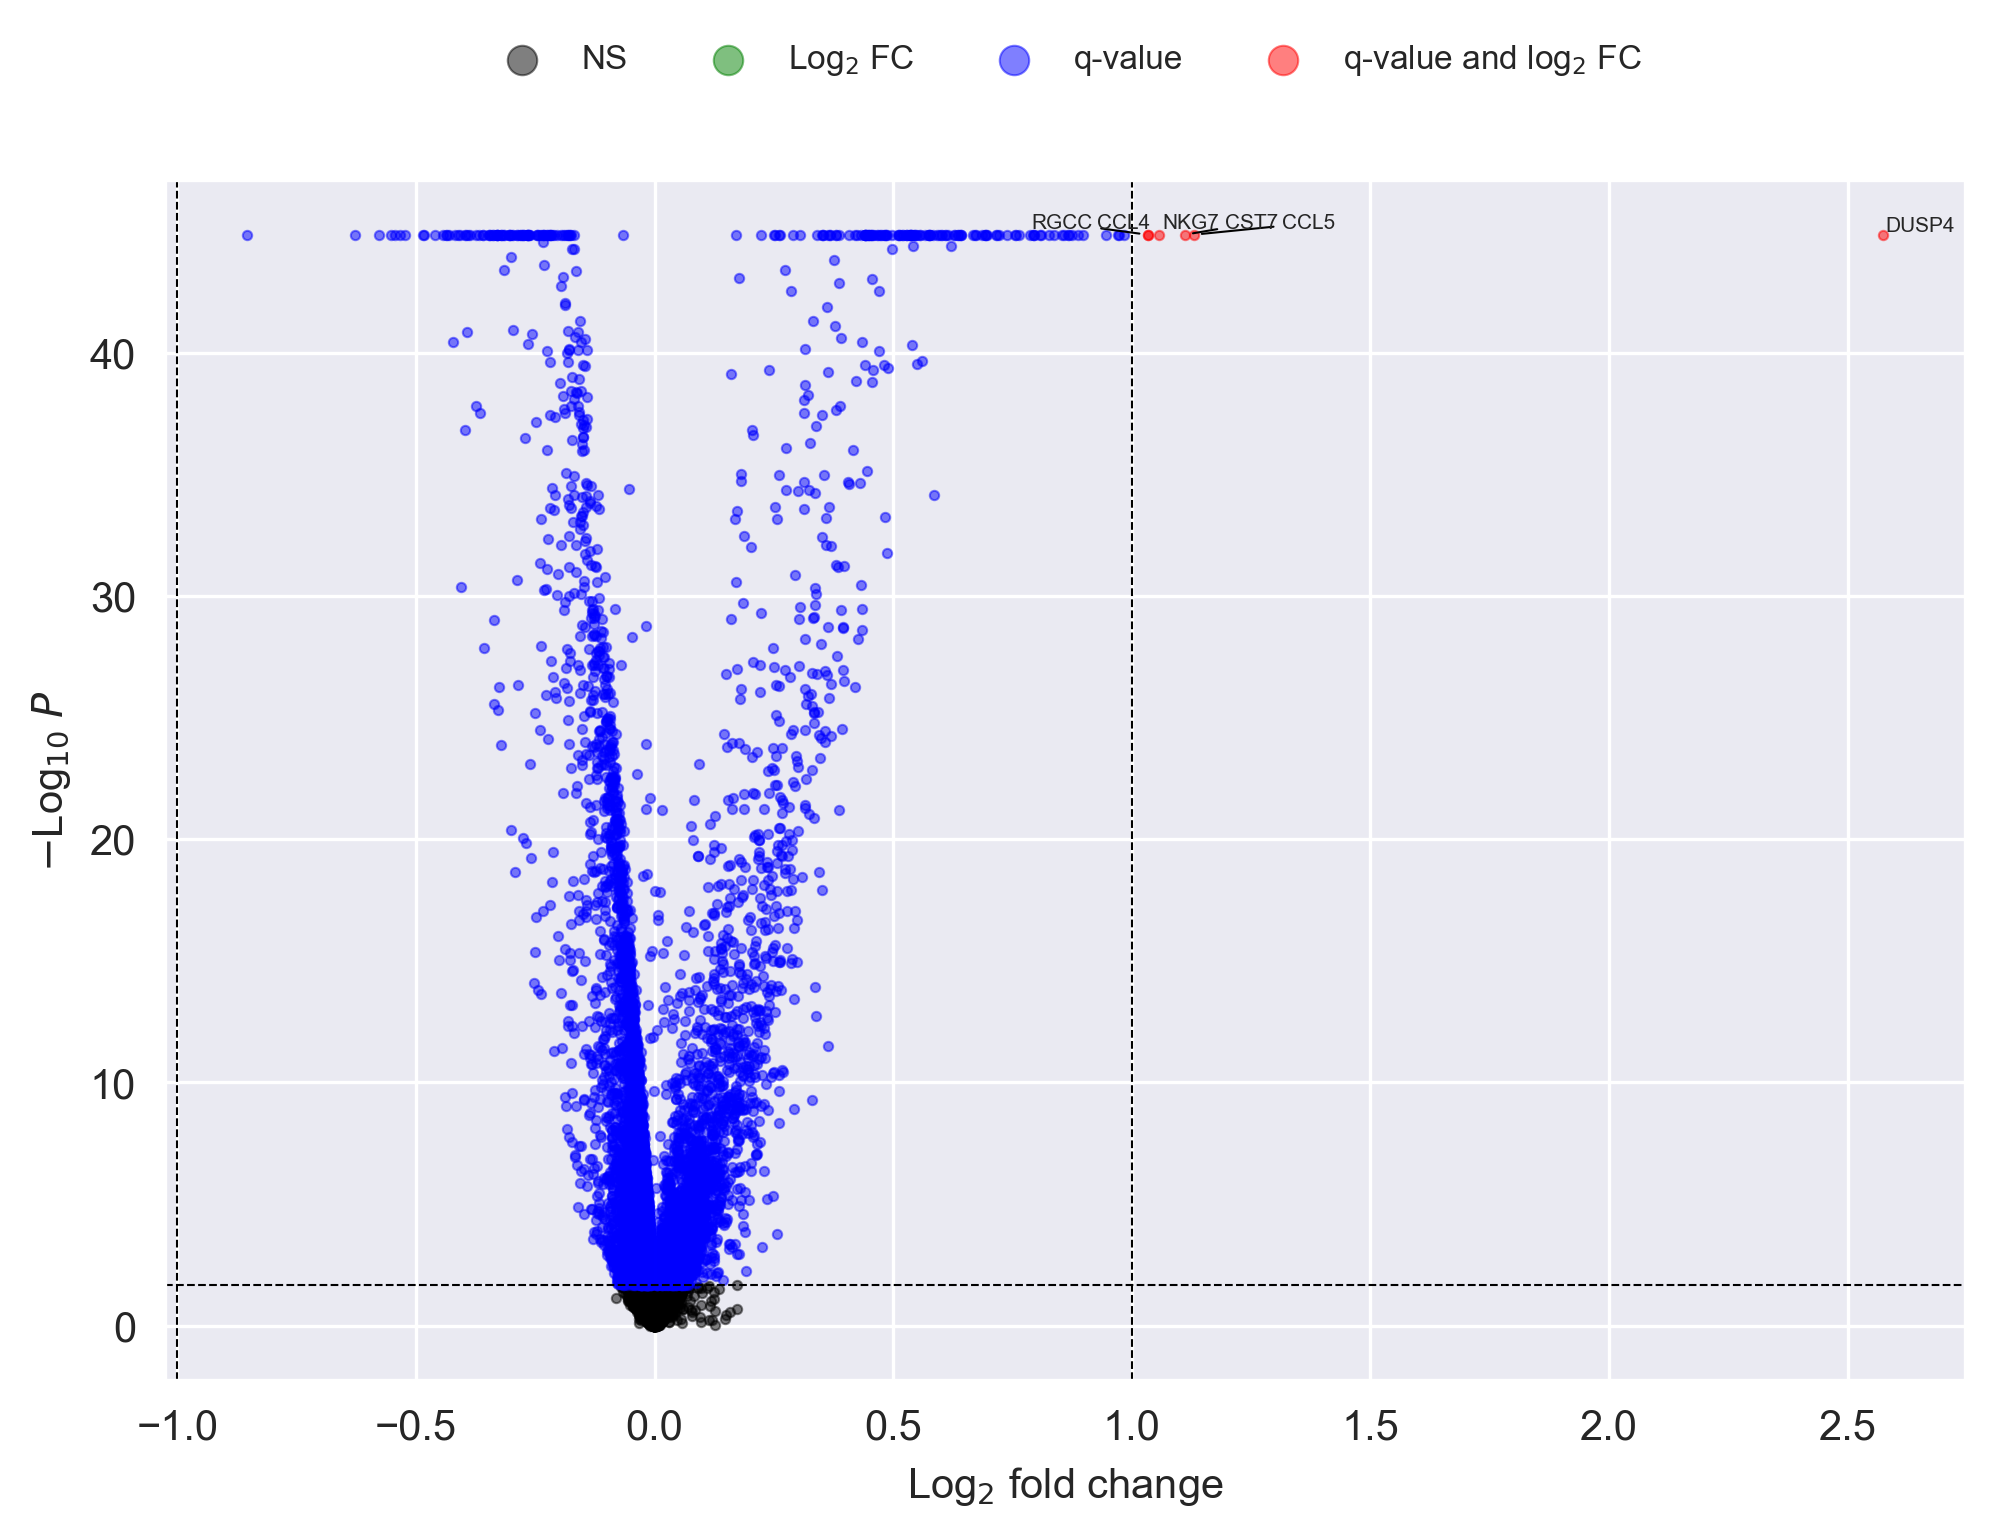

In [142]:
rna_filtered.obs['msi_status'] = rna_filtered.obs['msi_status'].astype('category')
sc.tl.rank_genes_groups(
    rna_filtered, 
    groupby='msi_status', 
    reference='rest', 
    method='wilcoxon'
)

# pegasus
pg.de_analysis(rna_filtered, cluster='msi_status')
pg.volcano(
    rna_filtered,  
    cluster_id='MSI-H',
    de_key='de_res',
    de_test='mwu',
    qval_threshold=0.05,
    log2fc_threshold=1.0, dpi=300
)

The Tumor microenvironment (TME) is made up a variety of components including extracellular matrix, cells that are not malignant (such as immune and stromal cells) and cancer cells.
Characterizing the TME is individualized to a patient as this makeup can be fairly heterogeneous from patient to patient. There are immune checkpoint inhibitors (ICI) and CAR-T therapies that respond better to patients with a certain tumor make-up. 

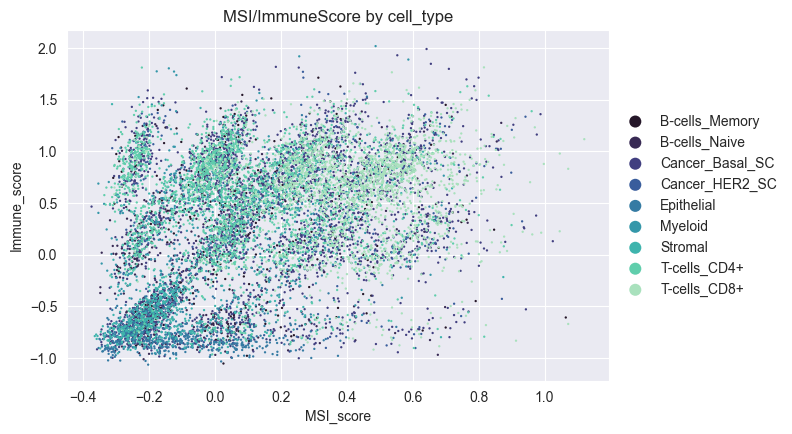

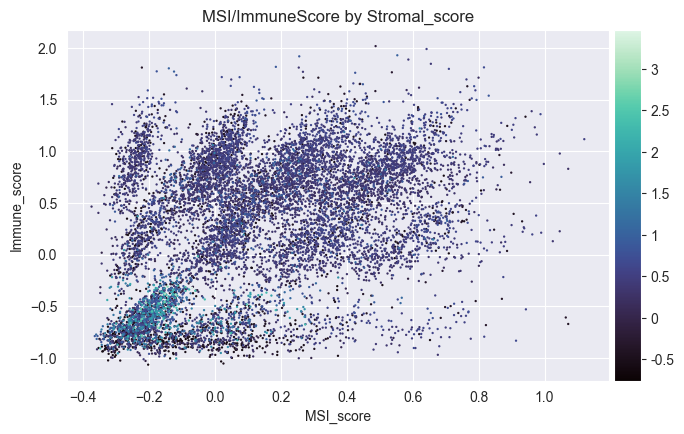

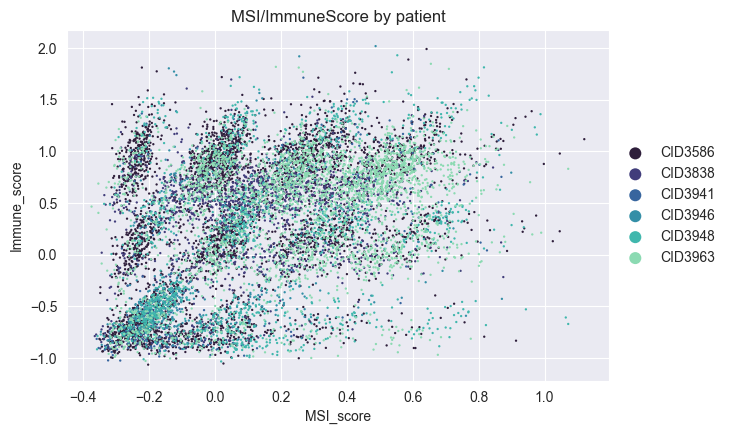

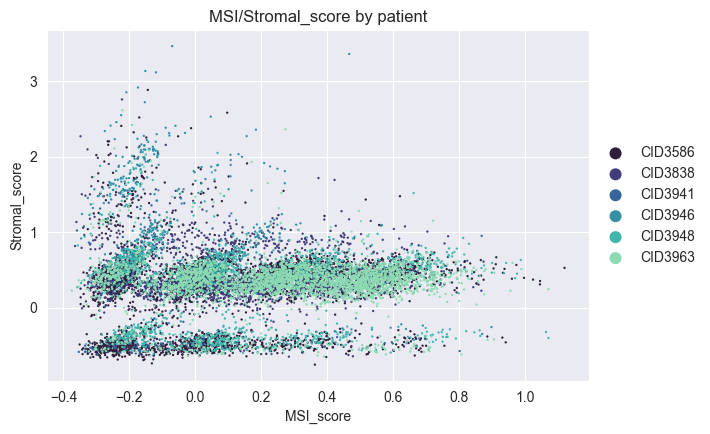

In [143]:
# MSI correlates with immune infiltration
immune_markers = ['CD8A', 'IFNG', 'GZMA', 'PRF1', 'IDO1', 'CXCL9', 'CXCL10']
sc.tl.score_genes(rna_filtered, immune_markers, score_name = 'immune_score')


# Compare MSI with stromal/immune components
tme_markers = {'Immune' : ['PTPRC', 'CD3E', 'CD68'],
               'Stromal': ['COL1A1', 'VIM', 'FAP']}

for tme, markers in tme_markers.items():
    markers_in_data = [m for m in markers if m in rna_filtered.var_names]
    if markers_in_data:
        sc.tl.score_genes(rna_filtered, markers_in_data, score_name = f'{tme}_score')

sc.pl.scatter(rna_filtered, x = 'MSI_score', y = 'Immune_score', color = 'predicted_celltype',
              title = 'MSI/ImmuneScore by cell_type')
sc.pl.scatter(rna_filtered, x = 'MSI_score', y = 'Immune_score', color = 'Stromal_score', color_map = 'mako',
              title = 'MSI/ImmuneScore by Stromal_score')
sc.pl.scatter(rna_filtered, x = 'MSI_score', y = 'Immune_score', color = 'patient', color_map = 'mako',
              title = 'MSI/ImmuneScore by patient')
sc.pl.scatter(rna_filtered, x = 'MSI_score', y = 'Stromal_score', color = 'patient', color_map = 'mako',
              title = 'MSI/Stromal_score by patient')

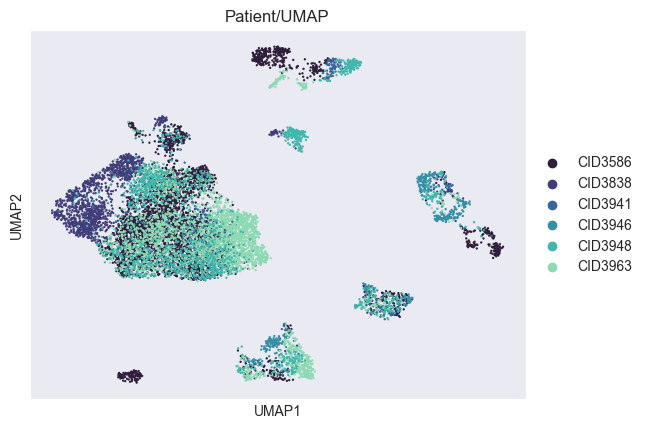

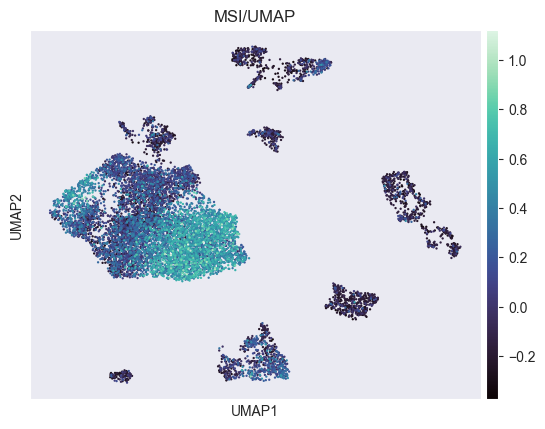

In [144]:
# Additional UMAP plots
sc.pl.umap(rna_filtered, color = 'patient', title = "Patient/UMAP", cmap = 'mako')
sc.pl.umap(rna_filtered, color = 'MSI_score', title = "MSI/UMAP",  cmap = 'mako')

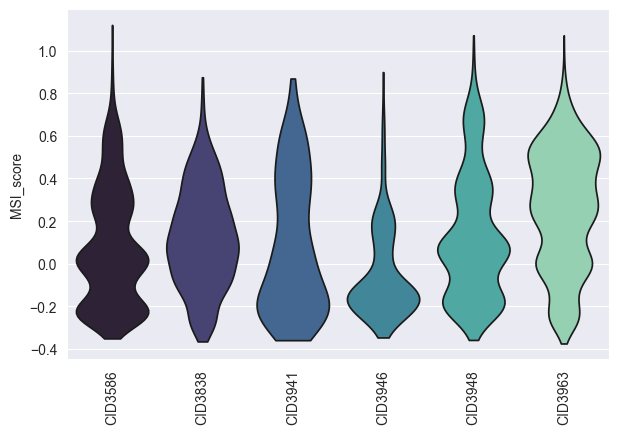

NameError: name 'ax' is not defined

In [145]:
# Violin plots
sc.pl.violin(rna_filtered,
             'MSI_score',
             color = patient_colors,
             groupby = 'patient',
             stripplot = False,
             jitter = .4,
             rotation = 90)
sc.pl.violin(rna_filtered, 'Immune_score',
             color = patient_colors,
             groupby = 'patient',
             stripplot = False,
             jitter = .4,
             ax=ax,
             rotation = 90)
ax.axhline(0, color='red', linestyle=':')
sc.pl.violin(rna_filtered, 'Stromal_score',
             color = patient_colors,
             groupby = 'patient',
             stripplot = False,
             jitter = .4,
             rotation = 90)

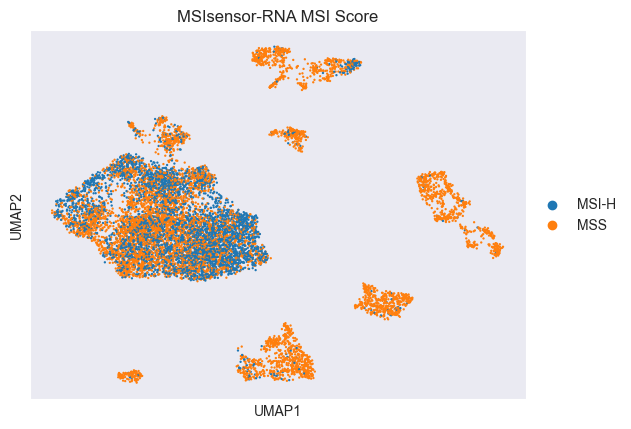

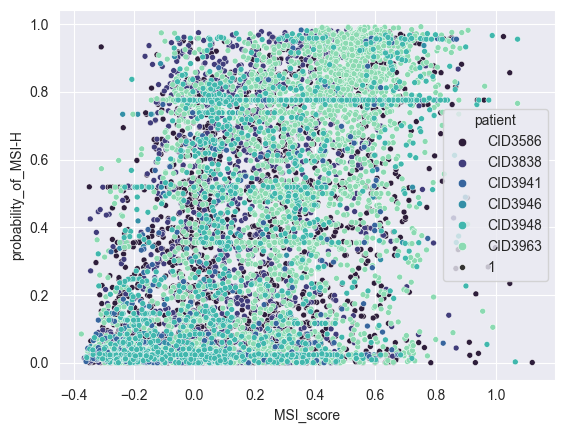

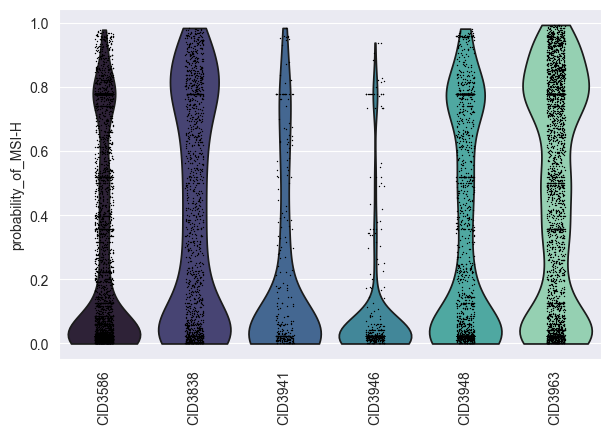

In [157]:
# Visualize MSIsensor predictions
sc.pl.umap(rna_filtered, color = 'msi_status',
           cmap = 'mako',
           title = 'MSIsensor-RNA MSI Score')

# Compare with your gene signature-based score

sns.scatterplot(x = rna_filtered.obs['MSI_score'],
                y = rna_filtered.obs['probability_of_MSI-H'],
                hue = rna_filtered.obs['patient'],
                palette = patient_colors,
                size = 1)

# Analyze MSI status by cell type
sc.pl.violin(rna_filtered, 'probability_of_MSI-H',
             groupby = 'patient',
             rotation = 90,
             color = patient_colors)

# # Patient-level MSI status based on cell aggregation
# patient_msi = rna_filtered.obs.groupby('patient')['MSIsensor_score'].mean().sort_values(ascending=False)
# fig, ax = plt.subplots(figsize=(12, 5))
# sns.barplot(x=patient_msi.index, y=patient_msi.values, ax=ax)
# plt.title('Patient-level MSI Score (MSIsensor-RNA)')
# plt.xticks(rotation=45)
# plt.tight_layout()

PearsonRResult(statistic=np.float64(0.22531606529677267), pvalue=np.float64(1.0069043937906819e-46))
1026.1038165963687 1.3404856707152296e-219


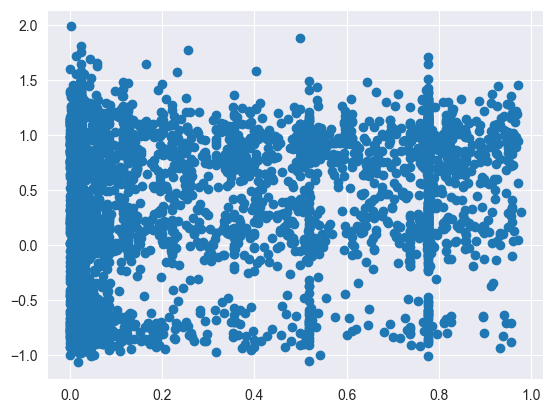

In [158]:
from scipy import stats

stat = 'probability_of_MSI-H'
stat2 = 'Immune_score'

g1 = rna_filtered[rna_filtered.obs['patient'].isin(['CID3586'])].obs[stat]
g1_i = rna_filtered[rna_filtered.obs['patient'].isin(['CID3586'])].obs[stat2]
g2 = rna_filtered[rna_filtered.obs['patient'].isin(['CID3838'])].obs[stat]
g3 = rna_filtered[rna_filtered.obs['patient'].isin(['CID3941'])].obs[stat]
g4 = rna_filtered[rna_filtered.obs['patient'].isin(['CID3946'])].obs[stat]
g5 = rna_filtered[rna_filtered.obs['patient'].isin(['CID3948'])].obs[stat]
g6 = rna_filtered[rna_filtered.obs['patient'].isin(['CID3963'])].obs[stat]
# print(g1)
rna_filtered.obs.to_csv("data/rna_filtered.csv")

# rna_filtered.to_parquet("data/rna_filtered.parquet")
print(stats.pearsonr(g1, g1_i))
# plt.boxplot([g1, g2, g3, g4, g5, g6])
plt.scatter(g1, g1_i, )
statistic, p_value = stats.kruskal(g1, g2, g3, g4, g5, g6)
print(statistic, p_value)
# print(stats.pearsonr(rna_filtered.obs['probability_of_MSI-H'], ))

(array([1069.,  233.,  153.,  228.,  186.,  198.,  185.,  513.,  362.,
         378.]),
 array([0.     , 0.09925, 0.1985 , 0.29775, 0.397  , 0.49625, 0.5955 ,
        0.69475, 0.794  , 0.89325, 0.9925 ]),
 <BarContainer object of 10 artists>)

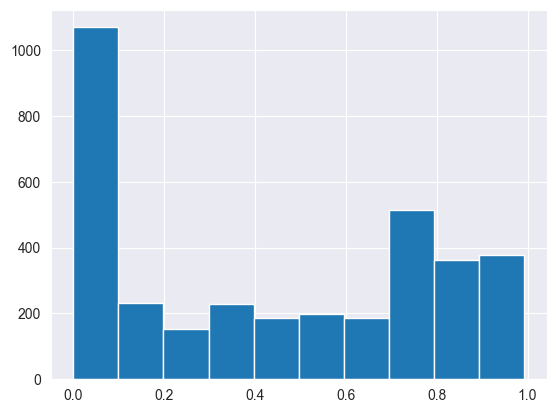

In [81]:
plt.hist(g6)